# Ejercicio 4: Estimación de parámetros cosmológicos

_Estima los parámetros cosmológicos $ \Omega_m $ y $ H_0 $ a partir de los datos dados, utilizando el método de las cadenas de Markov._

El _módulo de distancia $ \mu $_ está dado por la expresión

$$
\mu = 25 - 5\log_{10}(H_0/100) + 5\log_{10}(D_L/Mpc)
$$

donde $ H_0 $ es la constante de Hubble y

$$
D_L = \frac{c}{H_0}(1 + z)[\eta(1, \Omega_m) - \eta(1/(1 + z), \Omega_m)]
$$

Aquí, $ c $ es la velocidad de la luz, $ z $ es el corrimiento al rojo, $ \Omega_m $ es la densidad de masa bariónica mas materia oscura y

$$
\eta(a, \Omega_m) = 2\sqrt{s^3 + 1}[a^{-4} - 0.1540sa^{-3} + 0.4304s^2a^{-2} + 0.19097s^3a^{-1} + 0.066941s^4]^{-1/8}
$$

$$
s^3 = (1 - \Omega_m)/\Omega_m
$$

Lo que buscamos es maximizar la función _Likelihood $ L $_, o su logaritmo. Asumiendo una distribución gaussiana:

$$
ln(L(\vec{x}, \vec{y} | \vec{\theta})) = -\frac{1}{2} \sum_{i} \Bigg(\frac{(y_i - \lambda(x_i, \vec{\theta}))^2}{\sigma_i^2}\Bigg)
$$

In [19]:
import matplotlib. pyplot as plt
import numpy as np
from random import random, gauss
from pylab import rcParams
from math import log, exp

%matplotlib inline
rcParams['figure.figsize'] = (10, 6)

Text(0,0.5,'$\\mu$')

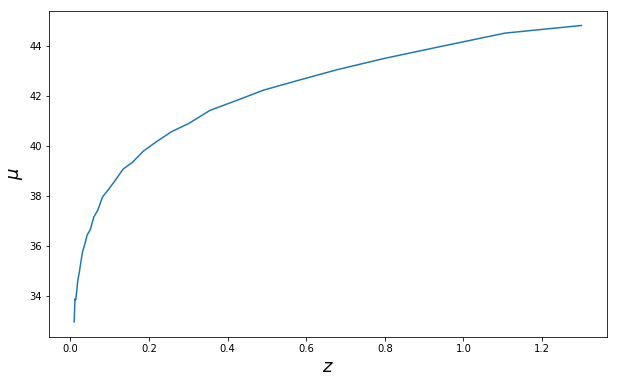

In [20]:
# Extraer datos desde archivos
cov_matrix = np.loadtxt('files/jla_mub_covmatrix.dat')
z = np.loadtxt('files/jla_mub.txt', usecols = 0)
mu = np.loadtxt('files/jla_mub.txt', usecols = 1)
varianza = []

# De cov_matrix solo nos interesa la varianza, que está en la diagonal
for i in range(31):
    varianza.append(cov_matrix[31 * i + i])
    
plt.plot(z, mu)
plt.xlabel(r'$z$', fontsize = 18)
plt.ylabel(r'$\mu$', fontsize = 18)

In [21]:
# Definición de las expresiones matemáticas
def s(omega_m):
    return ((1.0 - omega_m) / omega_m)**(1.0 / 3.0)

def eta(a, omega_m):
    return 2.0 * (s(omega_m)**3.0 + 1.0)**0.5 * (a**(-4.0) - 0.154 * \
           s(omega_m) * a**(-3.0) + 0.4304 * s(omega_m)**2.0 * a**(-2.0) + \
           0.19097 * s(omega_m)**3.0 * a**(-1.0) + 0.066941 * s(omega_m)**4.0)**(-1.0/8.0)

def D_L(z, H_0, omega_m):
    c = 3e5 # km/s
    return c * (1.0 + z) * (eta(1.0, omega_m) - eta(1.0 / (1.0 + z), omega_m)) / H_0

def dist_mu(z, H_0, omega_m):
    return 25.0 - 5.0 * log(H_0 / 100.0, 10.0) + 5.0 * log(D_L(z, H_0, omega_m), 10.0)

def log_likelihood(H_0, omega_m, mu_list, z_list, var_list): # ln(L)
    suma = 0.0
    
    for i in range(len(mu_list)):
        suma += ((mu_list[i] - dist_mu(z_list[i], H_0, omega_m)) / var_list[i])**2.0
        
    return -0.5 * suma

In [66]:
Nsamples = 10000
omega_sample = []
h_sample = []
h0 = 51.0
omega0 = 0.3
old_log_likelhd = log_likelihood(h0, omega0, mu, z, varianza)
new_log_likelhd = 0.0
aceptados = 0

for i in range(Nsamples):
    h_sample.append(h0)
    omega_sample.append(omega0)
    
    h = -1.0
    omega = -1.0
    while(h < 0 or h > 100):
        h = gauss(h0, 2.0)
    while(omega < 0.1 or omega > 1.0):
        omega = gauss(omega0, 0.05)
    
    new_log_likelhd = log_likelihood(h, omega, mu, z, varianza)
    diff = new_log_likelhd - old_log_likelhd
        
    if new_log_likelhd > old_log_likelhd:
        old_log_likelhd = new_log_likelhd
        h0 = h
        omega0 = omega
        aceptados += 1
    elif random() < new_log_likelhd:
        old_log_likelhd = new_log_likelhd
        h0 = h
        omega0 = omega
        aceptados += 1
        
print(len(omega_sample), aceptados)

10000 36


Text(0.5,1,'Valores de $H_0$ y $\\Omega_m$ utilizados')

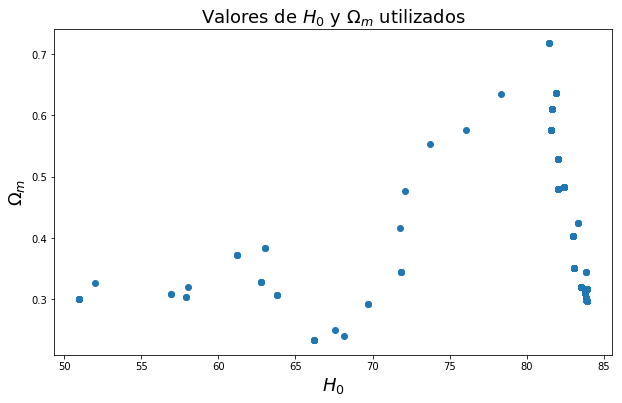

In [63]:
plt.plot(h_sample, omega_sample, 'o')
plt.xlabel(r'$H_0$', fontsize = 18)
plt.ylabel(r'$\Omega_m$', fontsize = 18)
plt.title(r'Valores de $H_0$ y $\Omega_m$ utilizados', fontsize = 18)